# 1. `ROOT` basics tutorial

Let's start by importing root and some other libraries needed for the following:

In [1]:
import sys
import os
import ROOT
import numpy as np # library of mathematical functions
import pandas as pd # library for data storage
import matplotlib.pyplot as plt # library for basic plotting
import seaborn as sb # library for statistical plotting

Welcome to JupyROOT 6.14/04


We use ROOT to read the file containing the events and to check what is inside the it:
* `TFile` is the ROOT library for the handling of files
* `GetListOfKeys()` returns the list of names of the object contained in the file
* `Get()` is the general function to get an object. It takes the name of the object as an input
* `GetEntries()` takes no input and returns the number of entries in the object on which it is called

But first, let's have a look at the structure of the root file.

### Reading the ROOT file

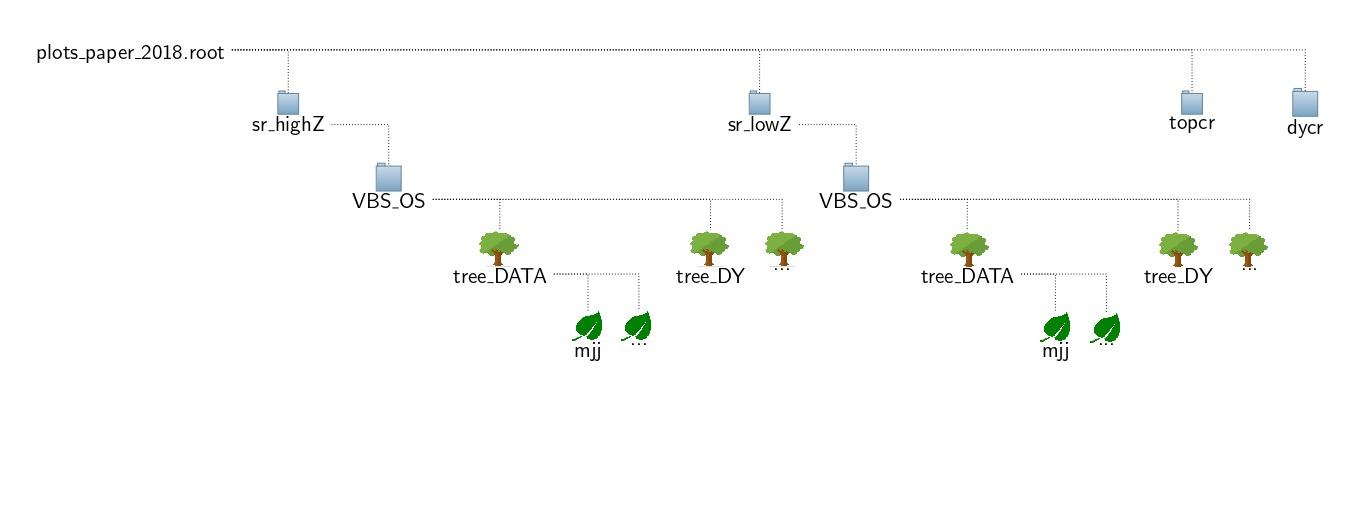

In [3]:
from IPython.display import Image
Image(filename='/home/llr/ilc/appro2/VBS_marco/images/structureroot.jpg') 

In [5]:
rfile = ROOT.TFile.Open('/home/llr/ilc/appro2/VBS_marco/plots_paper_2018.root')
rfile.GetListOfKeys().Print()

Collection name='THashList', class='THashList', size=4
 TKey Name = sr_highZ, Title = sr_highZ, Cycle = 1
 TKey Name = sr_lowZ, Title = sr_lowZ, Cycle = 1
 TKey Name = topcr, Title = topcr, Cycle = 1
 TKey Name = dycr, Title = dycr, Cycle = 1


Thanks to these commands the TFile is now open and the list of keys is displayed on screen.
These keys are folders: each folder corresponds to a kinematic region whose meaning will be explained in the next lessons.

Let's focus on the `sr_highZ` folder. Inside we can find 5 objects (called `TTree`), simply displayed with the following command.

In [6]:
rfolder = rfile.Get("sr_highZ/VBS_OS")
rfolder.GetListOfKeys().Print()

Collection name='THashList', class='THashList', size=5
 TKey Name = tree_DATA, Title = tree_DATA, Cycle = 1
 TKey Name = tree_DY, Title = tree_DY, Cycle = 1
 TKey Name = tree_WW, Title = tree_WW, Cycle = 1
 TKey Name = tree_WWewk, Title = tree_WWewk, Cycle = 1
 TKey Name = tree_top, Title = tree_top, Cycle = 1


In [7]:
for key in rfolder.GetListOfKeys():
    name = key.GetName()
    entries = rfolder.Get(name).GetEntries()
    print('{} : {}'.format(name,entries))

tree_DATA : 2514
tree_DY : 345
tree_WW : 495
tree_WWewk : 4210
tree_top : 6655


Inside the file there is a `TTree` with `26940 entries`. 

But what is a `TTree`? <br>
A `TTree` represents a columnar dataset. Any C++ type can be stored in its columns. A `TTree`, often called in jargon tree, consists of a list of independent columns or branches, represented by the `TBranch` class. Behind each branch, buffers are allocated automatically by `ROOT`. Such buffers are automatically written to disk or kept in memory until the size stored in the attribute `fMaxVirtualSize` is reached. Variables of one branch are written to the same buffer. A branch buffer is automatically compressed if the file compression attribute is set (default). Branches may be written to different files (see `TBranch::SetFile`). <br>
A full documentation about `TTree` can be found [here](https://root.cern.ch/doc/master/classTTree.html).

But what is there inside this tree? <br>
Let's check:

In [8]:
tree = rfolder.Get('tree_WWewk')
# tree.Print() idw why but thi command will broke the kernel. Please do not lauch it :)

## 1.1 Plotting and fitting

 Now that we have seen how to open and inspect a tree, let's see how to plot what is contained in it. In this first case I'm using `pyroot`, reading data directly in one of out TTree.

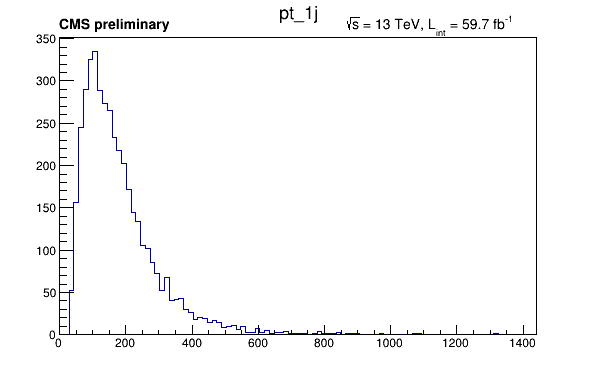

In [9]:
# Make global style changes
ROOT.gStyle.SetOptStat(0) # Disable the statistics box
ROOT.gStyle.SetTextFont(42)

# Create a canvas
c = ROOT.TCanvas('c', 'ciao', 600, 400)

# Create a histogram and draw it
h = ROOT.TH1F('histo', ';pt 1j; N_{Events}', 20, -5, 5)
tree.Draw("pt_1j>>h")

# Let's add some CMS style headline
label = ROOT.TLatex()
label.SetNDC(True)
label.SetTextSize(0.040)
label.DrawLatex(0.10, 0.92, '#bf{CMS preliminary}')
label.DrawLatex(0.58, 0.92, '#sqrt{s} = 13 TeV, L_{int} = 59.7 fb^{-1}')

# show interactively
c.Draw()

Now that we have seen this let's try and fill a histogram starting from the information inside a dataframe. This method is not very useful, especially if compared to the following.

It makes used of `uproot`, a special library for reading and writing ROOT files. This library is able to convert a TTree in a pandas dataframe or in a NumPy multidimensional array. I personally use dataframes for their practicality and immediate understanding.

In [13]:
import uproot

filename  = "plots_paper_2018.root"
name_tree = "sr_lowZ/VBS_OS/tree_WWewk"
branches  = ['mjj','pt_1j','pt_2j','eta_1j','ptll','eta_1l','Zepp_ll']

tree_signal = uproot.open(filename)[name_tree] # tree definition
signal_df   = tree_signal.arrays(branches, library = 'pd') # dataframe (df) definition

signal_df.head()

,mjj,pt_1j,pt_2j,eta_1j,ptll,eta_1l,Zepp_ll
0,1951.390503,776.513000,186.599106,-1.270996,353.902100,-0.400696,0.266937
1,950.362549,132.049515,80.302307,-2.045898,105.587074,0.410156,0.882690
2,2248.761719,204.169418,149.999985,-1.878662,217.748901,0.729370,0.365906
3,994.267212,144.991211,45.172977,-2.769043,61.031353,-0.563965,0.133545
4,2119.206787,195.250000,127.620102,-3.109375,93.341301,-1.928223,0.487633


This is the creating dataframe. It contains all the signal events contained in the sr_highZ folder with the properties we requested in the list `branches`.
To see how may events are contained in the dataframe, i.e. how many rows it has, we can ask the following:

In [14]:
signal_df.shape[0]

10365

In case of many (thousands) lines this extraction process can takes a pretty long time!! So you might consider doing the reading of the `ROOT` file only once, you save the info inside a `.csv` file and then from then on you just read the `.csv` file which is a way faster method of reading data. BUT: now this has the disadvantage that you will not be able to use the `ROOT` libraries on it.

Now that we have the DataFrame ready we can fill the histogram from the DataFrame.

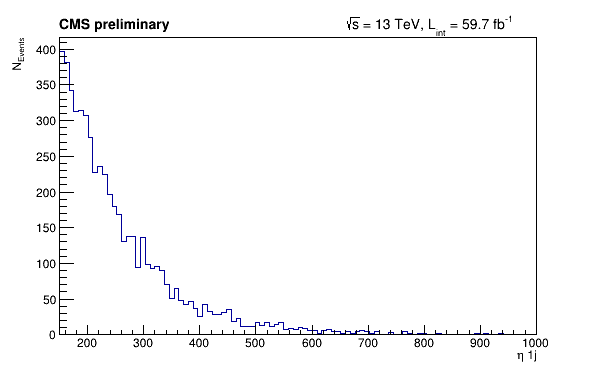

In [15]:
# Create a canvas
c1 = ROOT.TCanvas('c1', 'eta_1j - Pandas DataFrame', 600, 400)

# Create a histogram and draw it
h1 = ROOT.TH1F('h1', ';#eta 1j; N_{Events}', 100, 150, 1000)
for pt in signal_df["pt_1j"]:
    if pt > 150: # I put this cut just for the fitting purpose
        h1.Fill(pt)
h1.Draw()
    
# Let's add some CMS style headline
label = ROOT.TLatex()
label.SetNDC(True)
label.SetTextSize(0.040)
label.DrawLatex(0.10, 0.92, '#bf{CMS preliminary}')
label.DrawLatex(0.58, 0.92, '#sqrt{s} = 13 TeV, L_{int} = 59.7 fb^{-1}')

# show interactively
c1.Draw()

Now that we have a plot we can try to fit it with user defined functions using `ROOT`. We do it like this:

 FCN=5088.55 FROM HESSE     STATUS=FAILED         11 CALLS          68 TOTAL
                     EDM=4.99492e-14    STRATEGY= 1  ERROR MATRIX UNCERTAINTY 100.0 per cent
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0          -7.91755e+02   4.24264e-01   4.44057e+00   0.00000e+00
   2  p1           5.41547e-01   1.41421e+00   5.41547e-01   0.00000e+00
   3  p2           4.44057e+00   2.28565e-01   4.44057e+00  -9.77810e-07


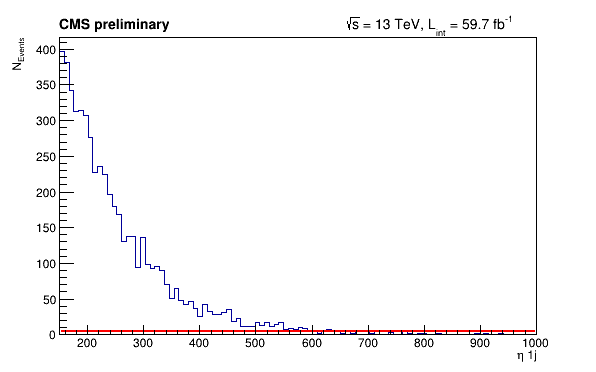

In [16]:
# Fit an inverse exponential function to the data
f = ROOT.TF1('f', '[0] * exp(-[1]*x) + [2]')
h1.Fit(f)

c1.Draw()

Why has the fit failed? Hint: what is the weak spot of every minimization (e.g. Newton-Rafson, bisection, etc.)? 

 FCN=88.8404 FROM MIGRAD    STATUS=CONVERGED     115 CALLS         116 TOTAL
                     EDM=8.35553e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.94134e+03   8.01155e+01   1.23650e-01   1.13507e-05
   2  p1           9.81824e-03   1.63791e-04   2.37418e-07  -4.45507e+00
   3  p2           6.04449e-01   2.77526e-01   1.05783e-03   8.21624e-04


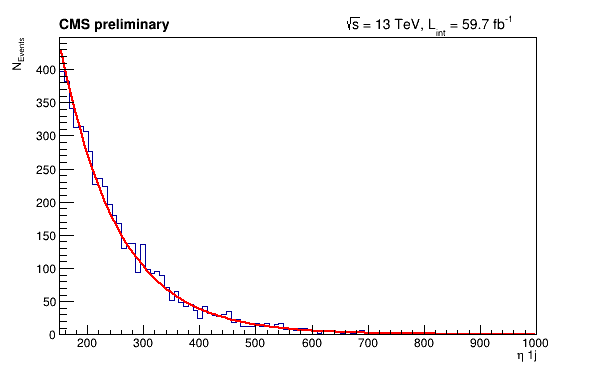

In [17]:
# Fit an inverse exponential function to the data
f = ROOT.TF1('f', '[0] * exp(-[1]*x) + [2]')
f.SetParameters(3000, 0.02, 0)
h1.Fit(f)

c1.Draw()

## 1.2 `RDataFrame` data handling

Although pandas dataframes are very convenient and widely used to create graphs and histogramns with libraries like matplotlib, their `ROOT` interface is not optimized.

The strength of a dataframe is that a plot can be created with a single command, directly passing to a the histogram an entire column and not the single values one by one. This is not possible with `ROOT`: as you can see some cells above for example, we had to use a for-loop to fill the histogram (`Fill()`). 
This process is very slow and does not exploit the full potential of a dataframe.

For this reasons, recently some implementations have been carried out to improve this comptibility and allow a high level interface for the analysis of data stored in `TTrees` --> `RDataFrame`. Indeed, with `RDataFrame`, it is possible to read, select, modify and write `ROOT` data, as well as easily produce histograms, cut-flow reports and other results.
In addition, multi-threading optimisations allow users to exploit all the resources available on their machines transparently.

In this and the following sections, you will learn how to perform data analysis with `RDataFrame`, running all your tasks efficiently on multiple threads!

`ROOT` tries to make parallelization as simple as possible for you. For this reason, we offer the feature `ROOT.EnableImplicitMT(N)`, which enables thread safety for the relevant classes and runs parallelized parts of `ROOT`, such as `RDataFrame`, implicitely on `N` threads:

In [18]:
# Enable multi-threading with the specified amount of threads (let's start with just one)
# Note that older ROOT versions require to write ROOT.ROOT.EnableImplicitMT()
ROOT.ROOT.EnableImplicitMT(1)

# Or enable multi-threading with an auto-detected amount of threads
#ROOT.ROOT.EnableImplicitMT()

### Plotting and fitting



A possible way to construct an `RDataFrame` is passing one (ore more) filepaths and the name of the dataset (i.e. the name of the `TTree` object in the file, which is called `tree_WWewk` for us).

In [21]:
df = ROOT.RDataFrame("sr_lowZ/VBS_OS/tree_WWewk", "/home/llr/ilc/appro2/VBS_marco/plots_paper_2018.root")

Next, you can apply selections and other transormations to the dataframe. The first basic transformation is applying cuts with the `Filter` method. Note that each transformation returns a new, transformed dataframe and does not change the dataframe object itself!

In [23]:
df_ptCut = df.Filter("pt_1j > 150", "Events where pt of the jet > 150 GeV")

At any point, you can book the computation of results, e.g., histograms or a report. Both of them are added below. Please note that `RDataFrame` is lazy! This means that the computation does not run right away, when you book a histogram, but you can accumulate multiple results and compute all of them in one go. The computation of all booked results is triggered only when you actually access one of the results, e.g with the command `c2.Draw()`!

In [24]:
report = df_ptCut.Report() 

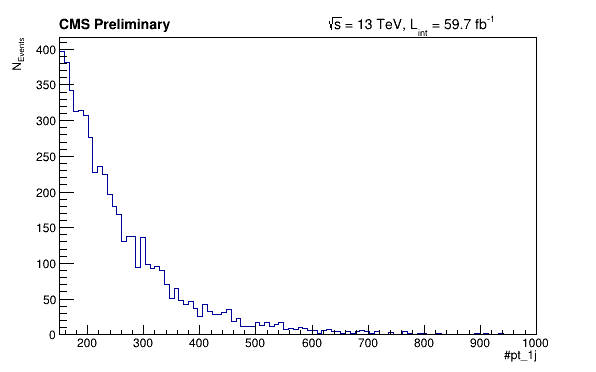

In [25]:
c2 = ROOT.TCanvas("c2", "pt_1j - RDataFrame", 600, 400)

# Booking the (lazy) filling of a histogram
h_pt = df_ptCut.Histo1D(('h1', ';#pt_1j; N_{Events}', 100, 150, 1000), "pt_1j")
h_pt.Draw()

label = ROOT.TLatex()
label.SetNDC(True)
label.SetTextSize(0.040)
label.DrawLatex(0.100, 0.920, "#bf{CMS Preliminary}")
label.DrawLatex(0.550, 0.920, "#sqrt{s} = 13 TeV, L_{int} = 59.7 fb^{-1}")

# show plot
c2.Draw()

 FCN=88.8404 FROM MIGRAD    STATUS=CONVERGED     115 CALLS         116 TOTAL
                     EDM=8.35552e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.94134e+03   8.01155e+01   1.23650e-01   1.13507e-05
   2  p1           9.81824e-03   1.63791e-04   2.37418e-07  -4.45507e+00
   3  p2           6.04449e-01   2.77526e-01   1.05783e-03   8.21624e-04


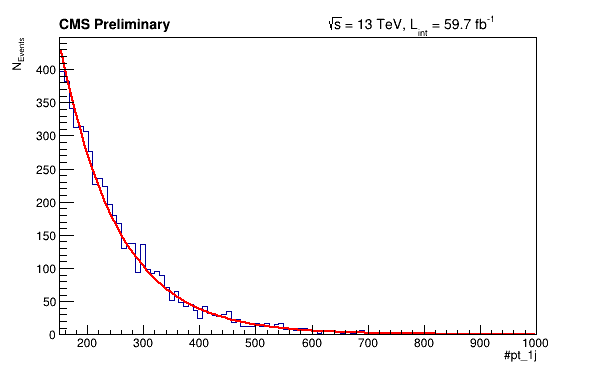

In [26]:
# Fit an inverse exponential function to the data
f = ROOT.TF1('f', '[0] * exp(-[1]*x) + [2]')
f.SetParameters(3000, 0.02, 0)
h_pt.Fit(f)

c2.Draw()

As explained above, accessing a dataframe result triggers the computation (sometimes called “event loop”) of all results booked up to that point. Here, this happens when we draw the histogram. However, you just have to remember to book all results first and then start working with the results so that they can all be computed in one go! 

We also print the cut-flow report to investigate the efficiency of the filters.

In [27]:
# Print the cut-applied report
report.Print()

Events where pt of the jet > 150 GeV: pass=5469       all=10365      --   52.764 %


In [28]:
# from ROOT import gROOT 
# gROOT.GetListOfCanvases().Draw()

### 1.3 Getting help with `ROOT`

The [`ROOT` website](https://root.cern) is home to the [beginner’s guide](https://root.cern/primer/) and the more in-depth [manual],(https://root.cern/manual/). These are a great resource to start with `ROOT` and learn about parts of the framework in high detail. Keep in mind the [`ROOT` website](https://root.cern), which provides links to all resources in a single place!

The [reference guide](https://root.cern/doc/master/index.html) provides a more technical documentation about `ROOT` powered by [Doxygen](https://www.doxygen.nl/index.html). You can search for classes or functions in `ROOT`, learn about types and methods and trace features down to the actual implementation.

Although the reference guide is more technical in first place, important classes have extensive additional documentation. Feel free to investigate [`TTree`](https://root.cern/doc/master/classTTree.html) or [`RDataFrame`](https://root.cern/doc/master/classROOT_1_1RDataFrame.html)!

Another part of the reference guide are the [tutorials](https://root.cern/doc/master/group__Tutorials.html), which explain features in working code examples. Feel free to look at tutorials for [`RooFit`](https://root.cern/doc/master/group__tutorial__roofit.html) and [`RDataFrame`](https://root.cern/doc/master/group__tutorial__dataframe.html), which cover many typical use cases for these parts of `ROOT`!

The [`ROOT` forum](https://root-forum.cern.ch/) is the to-go place if you cannot find the answer in the documentation. Don’t hesitate to open a discussion, there is always someone from the `ROOT` team actively taking care of new questions in the forum!

But not only questions are very welcome, you can also discuss possible improvements or make suggestions for new features!

### 1.5 For next time

You have all the knowledge you need to do plot and fit variables from a `ROOT` `TTree`, the only thing you need more is to know how the variables are called in the tree. For the moment, we just focus on these:
* `pt_l1` transverse momentum of the first lepton (electron or muon)
* `pt_l2` transverse momentum of the second lepton
* `eta_l1` eta of the first lepton
* `eta_l2` eta of the second lepton

* `pt_j1` transverse momentum of the first jet (electron or muon)
* `pt_j2` transverse momentum of the second jet
* `eta_j1` eta of the first jet
* `eta_j2` eta of the second jet

* `detajj` difference in eta between the two jets $\Delta\eta_{jj}$
* `dphill` difference in eta between the two leptons $\Delta\phi_{ll}$

Try to plot some of the variables listed above and think about which fit function could be used.

**WORK TOGETHER, I WOULD LIKE BOTH OF YOU TO ARRIVE WITH THE SAME LEVEL OF KNOWLEDGE OF WHAT YOU HAVE DONE!**

**LIKE ALWAYS, I AM AVAILABLE FOR ANY PROBLEM OR DOUBT. CONTACT ME ON SKYPE**